In [4]:
import cdsapi
import os
import xarray as xr
import numpy as np
from eofs.xarray import Eof
from eofs.examples import example_data_path
import matplotlib.pyplot as plt
import math
import pandas as pd
from matplotlib.patches import Rectangle



### Downloading ERA5 sea surface temperature data from Copernicus using CDSAPI

In [5]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "sea_surface_temperature",
        #"total_column_water_vapour",
        "land_sea_mask"
    ],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [63, 142, 38, -125]
}

client = cdsapi.Client()
client.retrieve(dataset, request,'north_pac_sst.nc')

2025-12-05 04:12:25,135 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-05 04:12:25,650 INFO Request ID is 5f54600b-9faf-49dc-a93e-8e7410075b05
2025-12-05 04:12:25,841 INFO status has been updated to accepted
2025-12-05 04:12:47,471 INFO status has been updated to successful


2d6b2131f2bc32af06f2b039da44afcd.nc:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

'north_pac_sst.nc'

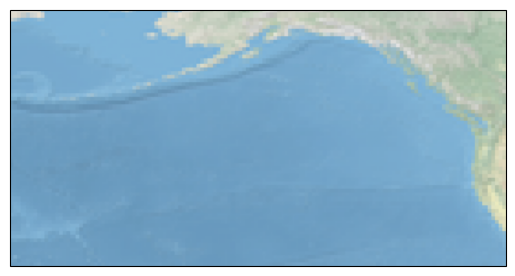

In [123]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.stock_img()
ax.set_extent([-120, 175, 30, 60])

plt.show()

In [6]:
ds = xr.load_dataset('north_pac_sst.nc')

In [7]:
ds

<xarray.Dataset> Size: 166MB
Dimensions:     (valid_time: 552, latitude: 101, longitude: 373)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 808B 63.0 62.75 62.5 ... 38.5 38.25 38.0
  * longitude   (longitude) float64 3kB 142.0 142.2 142.5 ... 234.5 234.8 235.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    sst         (valid_time, latitude, longitude) float32 83MB nan nan ... 286.6
    lsm         (valid_time, latitude, longitude) float32 83MB 0.9996 ... 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-05T00:36 GRIB to CDM+CF via cfgrib-0.9.1...

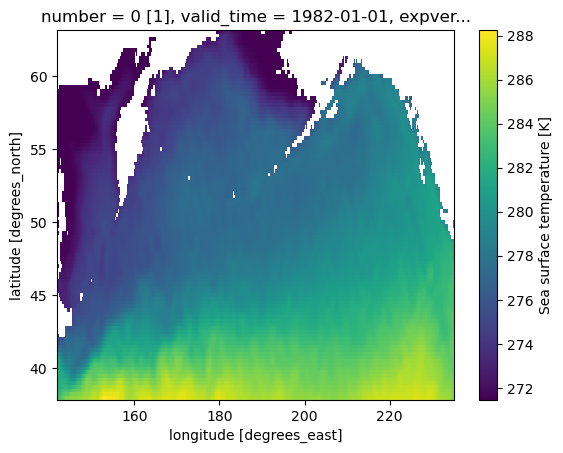

In [8]:
ds['sst'].sel(valid_time='1982-01-01').plot()

In [9]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")


def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)


def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [10]:
detr = linear_detrend(ds[["sst"]], time_dim="valid_time")

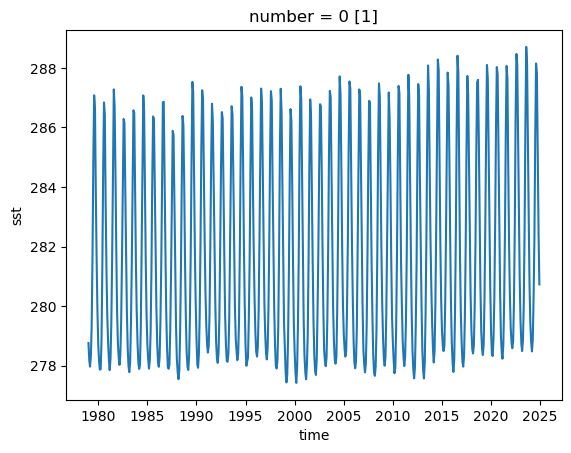

In [11]:
# plot of surface anomalies
ds['sst'].mean(dim=('latitude','longitude')).plot()

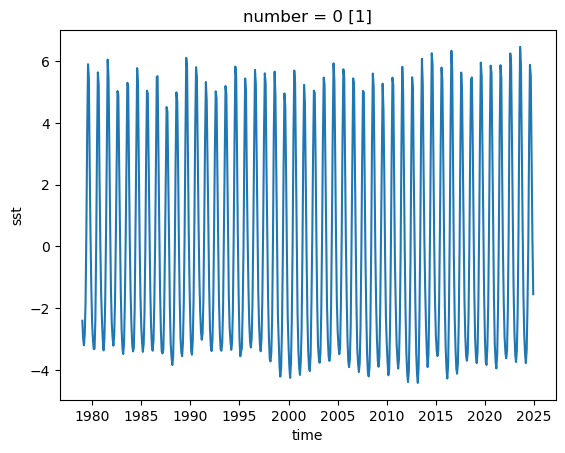

In [12]:
# plot of detrended surface anomalies
detr['sst'].mean(dim=('latitude','longitude')).plot()

In [13]:
# calculating anomalies 
anom, z = monthly_anom_and_z(detr, time_dim="valid_time")

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

In [30]:
# creating sea surface anomaly data array and preparing data array
anom_sst = anom['sst']
anom_sst = anom_sst.rename({"valid_time": "time"})
anom_sst_winter = anom_sst.where(anom_sst['time'].dt.month.isin([11,12,1,2]), drop=True)

In [31]:
anom_sst_winter

<xarray.DataArray 'sst' (time: 184, latitude: 101, longitude: 373)> Size: 28MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 5.588518  ,  6.0209813 ,  6.0042143 , ..., -1.0665969 ,
         -1.1028795 , -1.1032114 ],
        [ 5.8945208 ,  6.1360974 ,  6.1573734 , ..., -1.0364136 ,
         -1.060557  , -0.99472713],
        [ 5.850396  ,  6.0745425 ,  6.129759  , ..., -0.9742186 ,
         -0.97824657, -0.92742884]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 5.0701036 ,  5.652622  ,  5.7552366 , ...,  0.3250314 ,
          0.44226325,  0.5258163 ],
        [ 5.488369  ,  5.7958884 ,  5.8030977 , ...,  0.12125605,
          0.25454086,  0.4105398 ],
        [ 5.485084  ,  5.6663113 ,  5.4849243 , ..., -0.06568319,
          0.08378869,  0.31337184]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 4.8380585 ,  5.3260417 ,  5.487547  , ...,  0.18312737,
          0.21962291,  0.18662551],
        [ 4.9604464 ,  5.286882  ,  5.4315953 , ...,  0.16128972,
          0.21294686,  0.24309656],
        [ 4.9594755 ,  5.174013  ,  5.133611  , ...,  0.10762998,
          0.16899917,  0.21118829]]], shape=(184, 101, 373), dtype=float32)
Coordinates:
    number     (time) int64 1kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time       (time) datetime64[ns] 1kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude   (latitude) float64 808B 63.0 62.75 62.5 62.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float64 3kB 142.0 142.2 142.5 ... 234.5 234.8 235.0
    expver     (time) <U4 3kB '0001' '0001' '0001' ... '0001' '0001' '0001'
    month      (time) int64 1kB 1 2 11 12 1 2 11 12 1 ... 12 1 2 11 12 1 2 11 12

In [33]:
# creating the weights and creating the solver
coslat = np.cos(np.deg2rad(anom_sst_winter.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(anom_sst, weights=wgts)

In [34]:
eof = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=10, pcscaling=1)

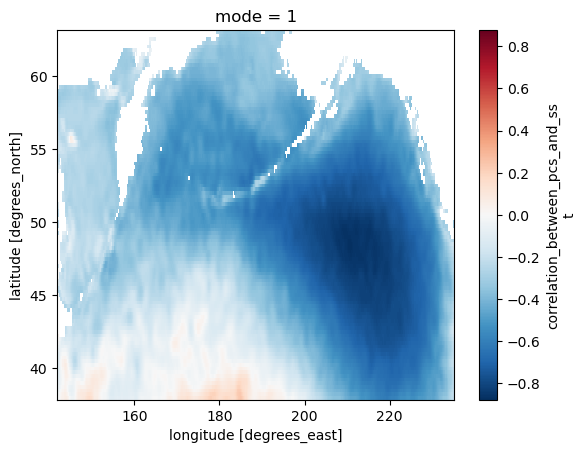

In [35]:
# plotting the first EOF
eof_1 = eof[1]
eof_1.plot()

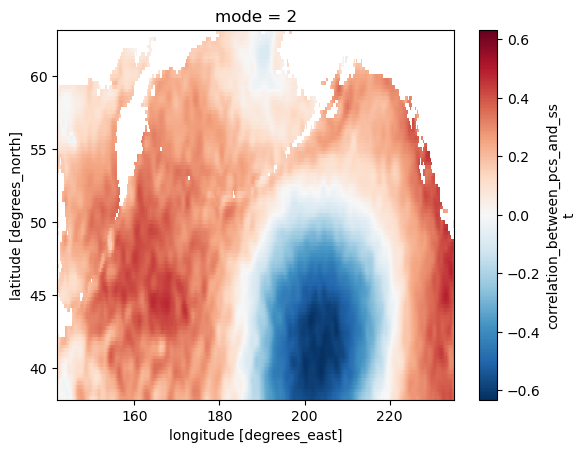

In [36]:
# plotting the second EOF
eof_2 = eof[2]
eof_2.plot()

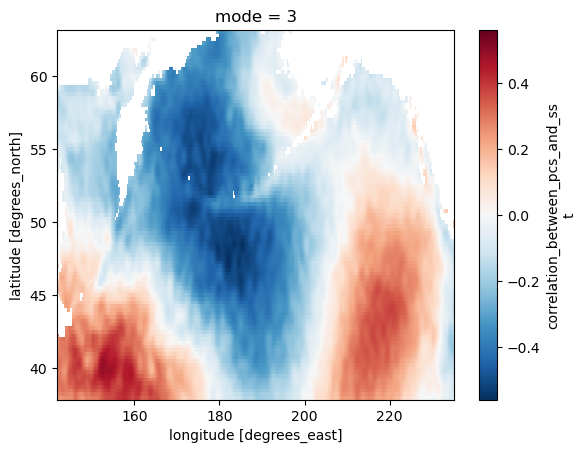

In [37]:
eof[3].plot()

In [22]:
varfrac = solver.varianceFraction()

(6.889364181712125e-16, 0.2322438657283783)

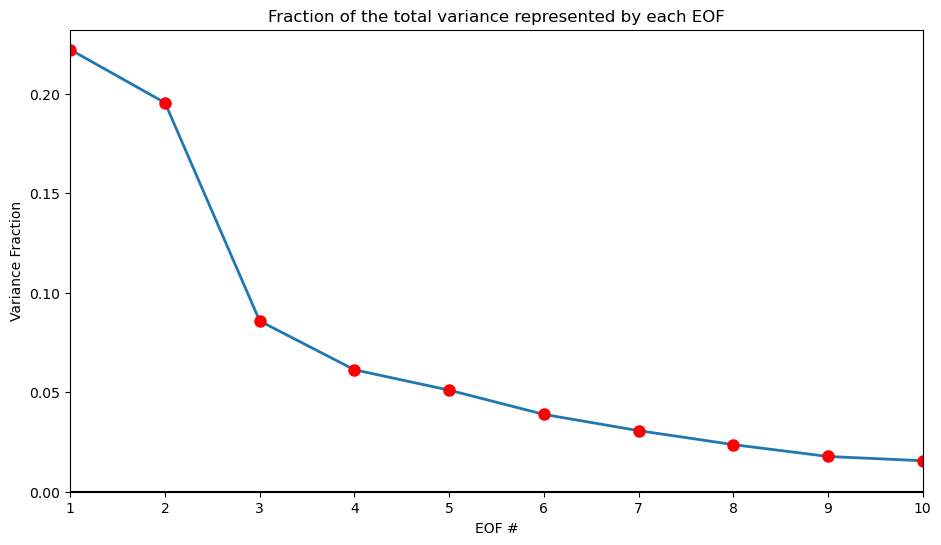

In [38]:
# Plot the percent of variance explained by the first 10 EOFs.
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

Text(0.5, 1.0, 'EOF 1 with High Variance Window')

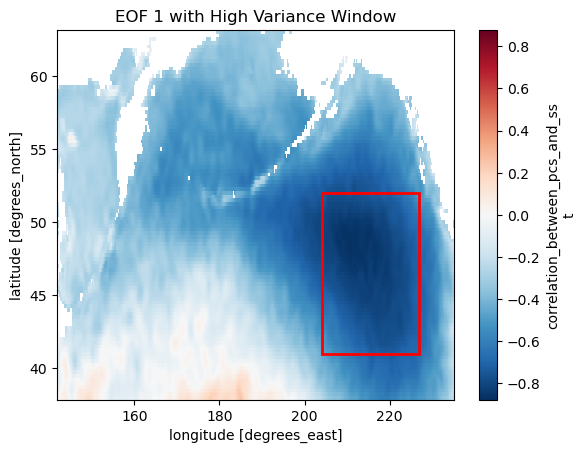

In [39]:
fig, ax = plt.subplots()
im = eof_1.plot()

lon_min, lon_max = 204,227
lat_min, lat_max = 41,52
width = lon_max - lon_min
height = lat_max - lat_min


rect = Rectangle(
    (lon_min, lat_min), width, height,
    linewidth=2, edgecolor='red', facecolor='none')

ax.add_patch(rect)

ax.set_title("EOF 1 with High Variance Window")


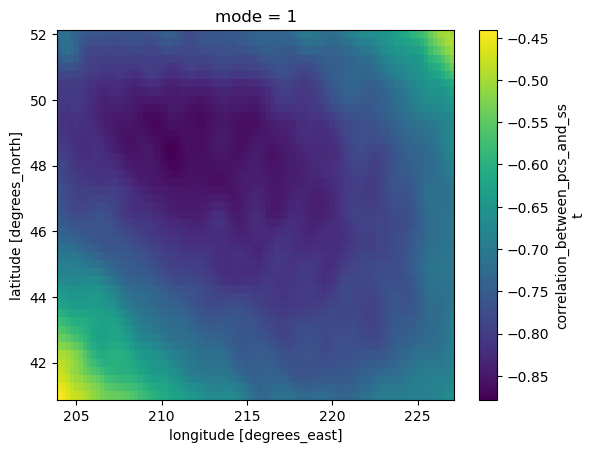

In [40]:
# Zoomed in window of high variance
eof_1.sel(longitude=slice(204,227),latitude=slice(52,41)).plot()

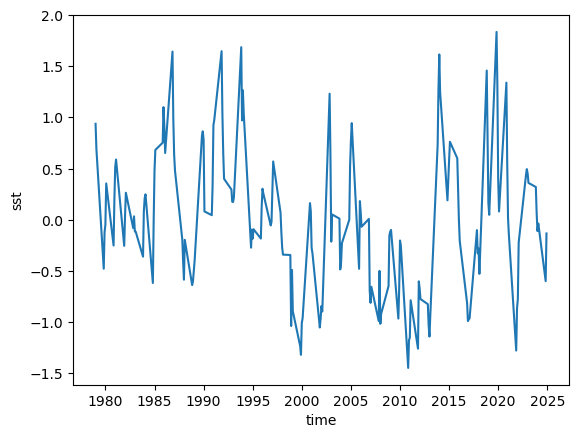

In [41]:
anom_sst_winter.sel(longitude=slice(204,227),latitude=slice(52,41)).mean(dim=('latitude','longitude')).plot()
anom_sst_winter_mean = anom_sst.sel(longitude=slice(204,227),latitude=slice(52,41)).mean(dim=('latitude','longitude'))


### Downloading ERA5 2 meter temperature data from Copernicus using CDSAPI

In [42]:
dataset = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["total_precipitation",
                 "2m_temperature"],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019", "2020", "2021",
        "2022", "2023", "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [49, -124, 23, -66]
}

client = cdsapi.Client()
client.retrieve(dataset, request,'usa_tp_t2m_sst.nc')

2025-12-05 04:52:36,296 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-05 04:52:36,715 INFO Request ID is cdb66327-6720-4045-a61c-da473916a07b
2025-12-05 04:52:36,863 INFO status has been updated to accepted
2025-12-05 04:52:58,564 INFO status has been updated to successful


3f23cbc46874410afbfe9eea53cedcb2.nc:   0%|          | 0.00/257M [00:00<?, ?B/s]

'usa_tp_t2m_sst.nc'

In [68]:
ds_us = xr.load_dataset('usa_tp_t2m_sst.nc')

In [69]:
ds_us

<xarray.Dataset> Size: 655MB
Dimensions:     (valid_time: 540, latitude: 261, longitude: 581)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 2kB 49.0 48.9 48.8 48.7 ... 23.2 23.1 23.0
  * longitude   (longitude) float64 5kB -124.0 -123.9 -123.8 ... -66.1 -66.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    tp          (valid_time, latitude, longitude) float32 328MB 0.002771 ... nan
    t2m         (valid_time, latitude, longitude) float32 328MB 269.7 ... nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-05T00:40 GRIB to CDM+CF via cfgrib-0.9.1...

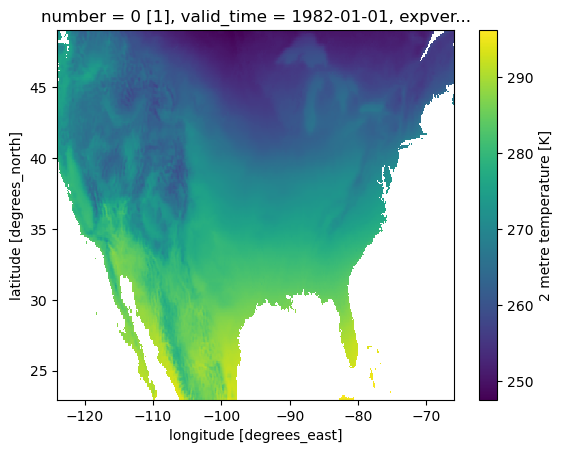

In [70]:
ds_us['t2m'].sel(valid_time='1982-01-01').plot()

In [71]:
detr_us = linear_detrend(ds_us[["tp","t2m"]], time_dim="valid_time")

In [72]:
anom_us, z_us = monthly_anom_and_z(detr_us, time_dim="valid_time")

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

In [73]:
z_t2m = z_us['t2m']
z_t2m = z_t2m.rename({"valid_time": "time"})
z_t2m_win = z_t2m.sel(time=z_t2m.time.dt.month.isin([11,12,1,2]))

In [74]:
coslat = np.cos(np.deg2rad(z_t2m_win.coords['latitude'].values))
wgts_t2m = np.sqrt(coslat)[..., np.newaxis]

In [75]:
out_corr = xr.corr(anom_sst_win.sel(longitude=slice(204,227),latitude=slice(52,41)).mean(dim=('latitude','longitude')), 
                    z_t2m_win,dim='time')

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


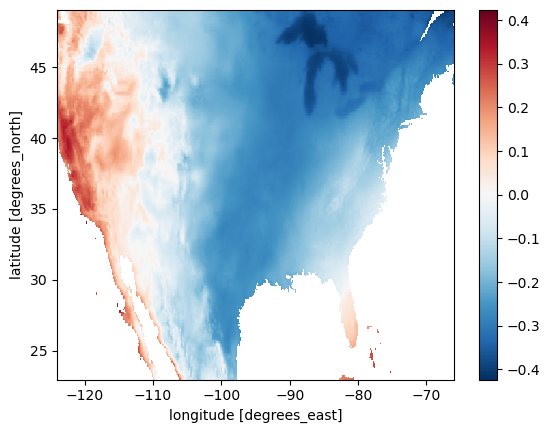

In [76]:
out_corr.plot()

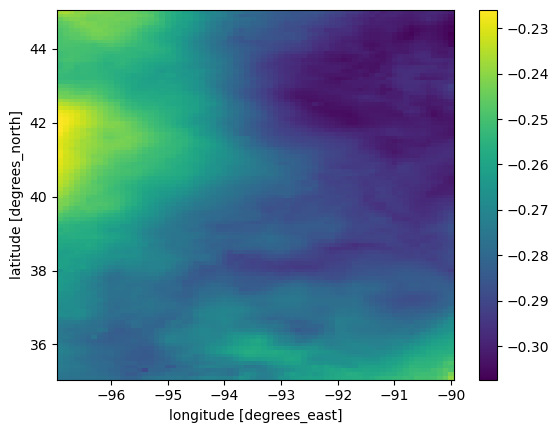

In [77]:
out_corr.sel(latitude=slice(45,35),longitude=slice(-97,-90)).plot()

In [78]:
t2m_mean

NameError: name 't2m_mean' is not defined

In [ ]:
t2m_anom = anom_us['t2m']
t2m_anom = t2m_anom.rename({"valid_time": "time"})
t2m_anom_win = t2m_anom.sel(time=t2m_anom.time.dt.month.isin([11,12,1,2]))
t2m_anom_sub = t2m_anom_win.sel(latitude=slice(45,35),longitude=slice(-97,-90))
sst_anom_sub = anom_sst_win.sel(longitude=slice(204,227),latitude=slice(52,41))
sst_anom_sub = sst_anom_sub.where(sst_anom_sub.time.dt.year != 2012, drop=True)

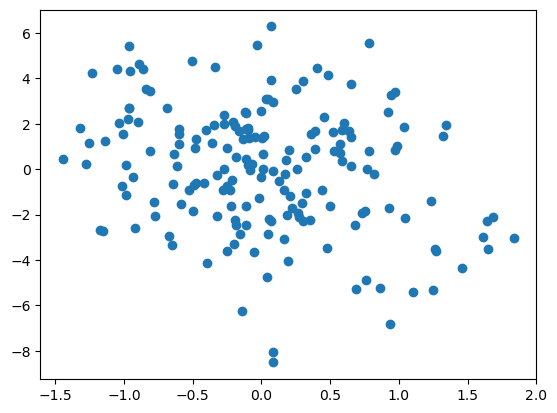

In [ ]:
sst_mean = sst_anom_sub.mean(dim=['latitude','longitude'])
t2m_mean = t2m_anom_sub.mean(dim=['latitude','longitude'])
plt.scatter(sst_mean,t2m_mean)


In [ ]:
d_sst = pd.DataFrame(anom_sst_win['time'],columns=['sst'])
d_t2m = pd.DataFrame(t2m_anom_win['time'],columns=['t2m'])

In [ ]:
d_sst[~d_sst['sst'].isin(d_t2m['t2m'])]

,sst
132,2012-01-01
133,2012-02-01
134,2012-11-01
135,2012-12-01


ValueError: x and y must be the same size

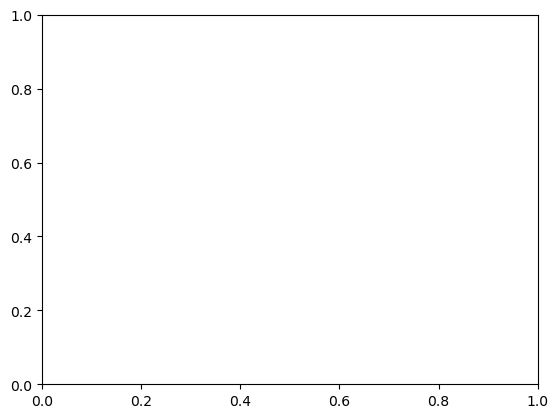

In [ ]:
plt.scatter(t2m_anom_sub[0][0],sst_anom_sub[0][0])

1260000